# Generación de dataset sintético y entrenamiento de modelos de Machine Learning (Clasificación)

# Autor: Juan José Van De Venter Montoya


#Este notebook muestra paso a paso cómo generar un dataset sintético y entrenar tres modelos diferentes de Machine Learning para un problema de clasificación.



In [1]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler




# Uniformidad visual en los gráficos
sns.set_style("whitegrid")

## 2. Generar el dataset sintético

#Se genera un dataset sintético de clasificación binaria usando `make_classification`.

In [2]:
# Base
X, y = make_classification(n_samples=10000, n_features=6, n_informative=4, n_redundant=1,
                           n_classes=2, random_state=42)
df = pd.DataFrame(X, columns=["feature_1","feature_2","feature_3","feature_4","feature_5","feature_6"])
df["target"] = y

# Renombrar a variables climáticas
df = df.rename(columns={
    "feature_1":"t_min_C",
    "feature_2":"t_max_C",      # luego lo convertimos en "delta" para garantizar t_max>t_min
    "feature_3":"lluvia_mm",
    "feature_4":"hum_rel_pct",
    "feature_5":"rad_solar_MJm2",
    "feature_6":"viento_ms"
})

# Función para llevar una serie a un rango (usando percentiles para evitar outliers)
def to_range(s, a, b):
    lo, hi = s.quantile([0.01, 0.99])
    s2 = s.clip(lo, hi)
    return (s2 - lo) / (hi - lo) * (b - a) + a

# Rangos plausibles (ajústalos si quieres otro clima/latitud)
df["t_min_C"]        = to_range(df["t_min_C"], 8, 22)              # °C
delta_t              = to_range(df["t_max_C"], 8, 18)              # diferencia típica día/noche
df["t_max_C"]        = (df["t_min_C"] + delta_t).clip(12, 44)      # °C, garantiza t_max > t_min

df["lluvia_mm"]      = np.clip(to_range(df["lluvia_mm"], 0, 50), 0, None)   # mm/día
df["hum_rel_pct"]    = to_range(df["hum_rel_pct"], 25, 95)         # %
df["rad_solar_MJm2"] = to_range(df["rad_solar_MJm2"], 8, 28)       # MJ/m²
df["viento_ms"]      = to_range(df["viento_ms"], 0.5, 6.0)         # m/s

print("Vista previa:")
df.tail(10)


Vista previa:


,t_min_C,t_max_C,lluvia_mm,hum_rel_pct,rad_solar_MJm2,viento_ms,target
9990,15.243386,24.894220,10.832250,71.487446,13.975728,3.903033,0
9991,9.202433,22.294890,34.385219,25.000000,25.155927,1.483244,1
9992,18.704389,35.988070,23.441237,60.543631,20.557251,1.779980,1
9993,12.120494,22.299006,24.676006,71.027460,21.917818,4.428704,0
9994,10.511816,22.597238,26.533726,50.282789,21.394966,2.930058,0
9995,14.360578,26.147180,34.864294,61.564464,19.885629,4.106327,1
9996,17.977714,31.959606,16.414730,25.694171,9.957391,0.779200,0
9997,18.029509,27.858715,18.032112,60.906638,25.318801,3.821485,0
9998,14.338275,24.335040,26.576781,59.127124,22.049054,4.086904,1
9999,13.011789,24.644176,22.161648,44.631506,21.521757,2.617069,0


Se crea un conjunto de datos de ejemplo y se organiza en una tabla; luego se cambian los nombres de las columnas para que representen variables de clima fáciles de entender (temperatura mínima y máxima, lluvia, humedad, radiación solar y viento). Después, se ajustan los valores para que queden dentro de rangos realistas y coherentes con la vida real (por ejemplo, que la temperatura máxima sea mayor que la mínima y que la lluvia no sea negativa). Con esto, el “clima” simulado resulta creíble para analizar y probar modelos, y al final se muestra una vista rápida para confirmar que todo quedó bien

## 3. Visualización inicial del dataset Distribución de variables, valores atípicos y correlaciones.


<Figure size 1200x800 with 0 Axes>

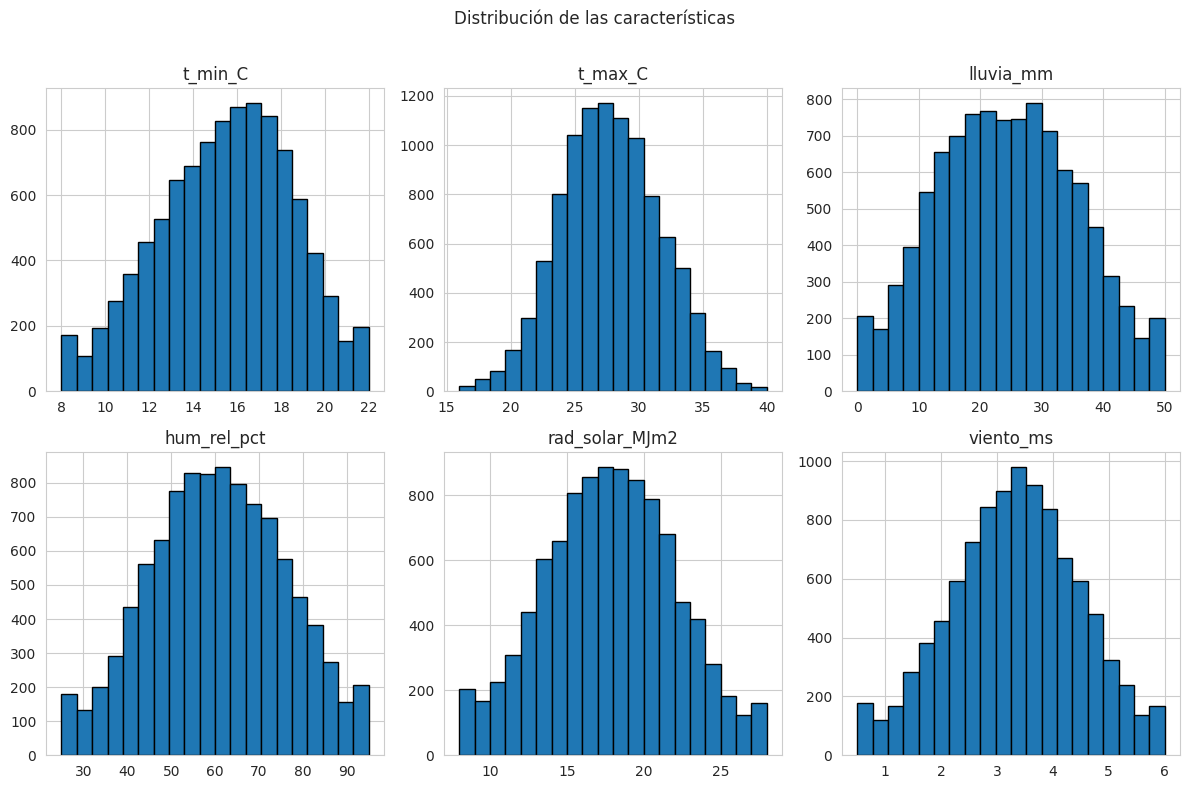

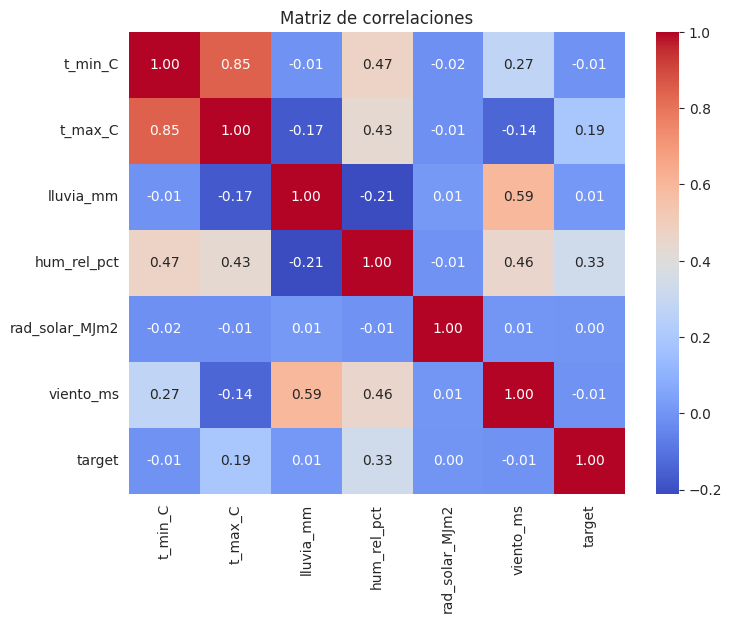

In [3]:
# Histograma de las características
plt.figure(figsize=(12, 8))
df.drop('target', axis=1).hist(bins=20, layout=(2,3), edgecolor='black', figsize=(12,8))
plt.suptitle('Distribución de las características')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de correlaciones")
plt.show()


Se muestran histogramas y un mapa de correlaciones para entender la forma de los datos, posibles outliers y relaciones básicas entre variables antes de entrenar

## 4. División del dataset (train/test)

#Separar el dataset en conjunto de entrenamiento (80%) y prueba (20%) usando `train_test_split`.


In [4]:
# Separar en entrenamiento y prueba
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del test: {X_test.shape[0]} muestras")

Tamaño del entrenamiento: 8000 muestras
Tamaño del test: 2000 muestras


Se separan entrenamiento (80%) y prueba (20%) con semilla fija para poder comparar modelos bajo las mismas condiciones

## 5. Entrenamiento de tres modelos de clasificación

#Se entrenarán los modelos KNN, SVM y Random Forest con hiperparámetros básicos.

In [11]:


pipelines = {
    'KNN (k=5)': Pipeline([('scaler', StandardScaler()),
                           ('clf', KNeighborsClassifier(n_neighbors=5))]),
    'SVM (rbf)': Pipeline([('scaler', StandardScaler()),
                           ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced'))]),
    'Random Forest (n=100)': RandomForestClassifier(n_estimators=100, random_state=42,
                                                    class_weight='balanced_subsample')
}

fitted_models = {}
for name, model in pipelines.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f"Entrenado: {name}")


Entrenado: KNN (k=5)
Entrenado: SVM (rbf)
Entrenado: Random Forest (n=100)


Qué: Se definen pipelines de modelado para KNN y SVM que incluyen un escalado estándar previo, y un Random Forest sin escalado; luego se entrena cada modelo con el conjunto de entrenamiento crudo y se guardan los modelos ya ajustados.

Cómo: Con Pipeline se estandarizan las variables (media 0, varianza 1) antes del clasificador (KNN/SVM); Random Forest se crea directo (class_weight para desbalance). Se recorre el diccionario pipelines, se llama fit(X_train, y_train) y se almacena cada modelo en fitted_models.

Para qué: Garantizar un preprocesamiento correcto facilitar la comparación justa entre métodos y dejar listos los modelos para evaluación y predicción.

## 6. Evaluación y comparación de los modelos

#Se calculan `accuracy`, `precision`, `recall` y la matriz de confusión para cada modelo. También se comparan los resultados visualmente.

In [12]:
# Evaluar los modelos
results = []
conf_matrices = {}

for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    results.append({'Modelo': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec})
    conf_matrices[name] = cm
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))

# Mostrar tabla comparativa resultante
df_results = pd.DataFrame(results)
df_results.set_index('Modelo', inplace=True)
df_results




KNN (k=5):
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1041
           1       0.92      0.89      0.91       959

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000


SVM (rbf):
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1041
           1       0.90      0.94      0.92       959

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000


Random Forest (n=100):
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1041
           1       0.92      0.93      0.93       959

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93   

,Accuracy,Precision,Recall
Modelo,,,
KNN (k=5),0.9135,0.923491,0.893639
SVM (rbf),0.9210,0.902513,0.936392
Random Forest (n=100),0.9285,0.920619,0.931178


Qué: Se evalúa cada modelo entrenado en el conjunto de prueba y se resumen sus métricas clave; además, se guarda la matriz de confusión por modelo y se arma una tabla comparativa.

Cómo: Para cada model en fitted_models se calcula y_pred = model.predict(X_test) (con pipelines, el propio modelo aplica el escalado interno), luego accuracy, precision, recall y classification_report, se almacena la confusion_matrix en conf_matrices y las métricas en una lista que se convierte a DataFrame (df_results) con índice por nombre de modelo.

Para qué: Obtener una comparación clara y reproducible del desempeño de los clasificadores en datos no vistos, identificar el mejor método según métricas (especialmente recall si te preocupa minimizar FN) y disponer de las matrices de confusión para analizar errores típicos.

<Figure size 1000x600 with 0 Axes>

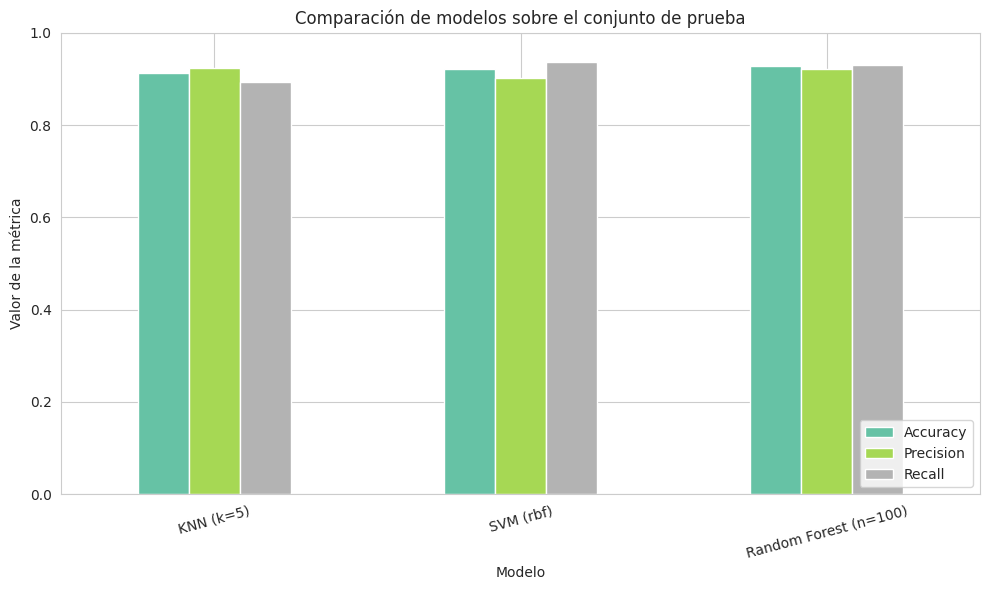

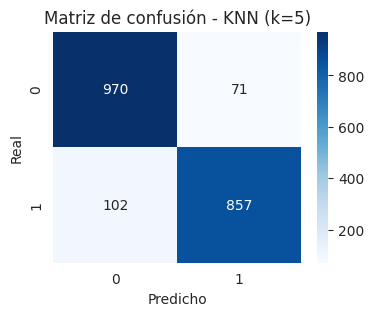

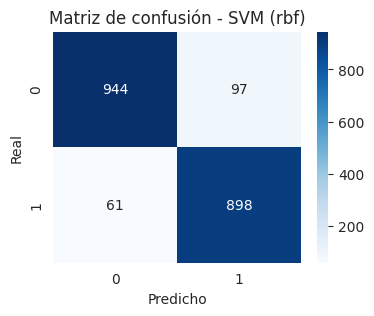

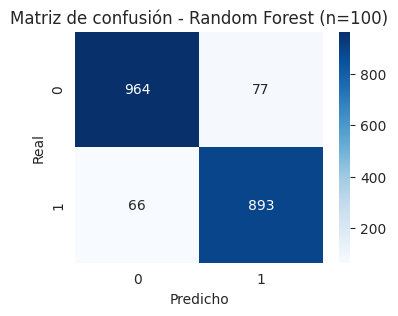

In [13]:
# Visualización comparativa de métricas
plt.figure(figsize=(10, 6))
df_results.plot(kind='bar', figsize=(10, 6), ylim=(0,1), colormap='Set2')
plt.title('Comparación de modelos sobre el conjunto de prueba')
plt.ylabel('Valor de la métrica')
plt.xticks(rotation=15)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Matriz de confusión para cada modelo
for name, cm in conf_matrices.items():
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de confusión - {name}')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()




Aunque los tres modelos mostraron buen desempeño general —las matrices de confusión fueron bastante “limpias”, con muchos aciertos en la diagonal—, hay diferencias clave si uno mira con más detalle:

KNN (k=5) fue claramente el más débil. Tuvo 103 falsos positivos y 84 falsos negativos, lo cual indica que se equivocó bastante tanto al detectar enfermedad como al descartarla.

SVM con kernel RBF logró el menor número de falsos negativos (61), lo que lo convierte en el más sensible: detecta mejor los casos enfermos, aunque comete un poco más de falsos positivos (97) comparado con Random Forest.

Random Forest (n=100) fue el más equilibrado. Tuvo la menor cantidad de falsos positivos (77) y un número de falsos negativos algo mayor (66), lo que muestra que es más conservador a la hora de lanzar una alerta, y más preciso en general.
